# Trabalho 1 - Machine Learning II 
Prof: Carlos Padilha

#### Alunos:  

Roberto A. Coutinho  
Thais Galho


## Sistemas com Multi-classificadores ou Ensembles

#### Este trabalho visa avaliar o entendimento em relaçãao á construção de sistemas com multi-classificadores ou ensembles. Para tal, os alunos deverão fazer o seguinte:


* Implementar o algoritmo AdaBoost (nos mesmos moldes que fizemos com o algoritmo Bagging).
    – Podem escolher qualquer tipo de classificador (MLP, SVM, etc).
* Processar os dados presente no arquivo sonar.all-data.
* Realizar treinamento e teste usando validação cruzada com 10 folds.
* Avaliar os resultados em termos de acurácia, recall e precisão.

Obs: O trabalho pode ser feito em dupla e deve ser enviado por email (carlos.engcomp@gmail.com).

# Imports

In [2]:
import numpy as np
import pandas as pd

# Modelos
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# K-fold CrossValidation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Leitura do dataset
 - Importação do dataset
 - Categorização da coluna de label
 - Embaralhamento da dsitribuição do dataset
     - Obs: O dataset estava ordernado com a primeira classe nos primeiros 50% e a segunda classe nos outros 50%. 

In [3]:
# Import dos dados
imported_data = pd.read_csv('sonar.all-data.csv', header=None)

# Categorização
imported_data.iloc[:,-1] = imported_data.iloc[:,-1].astype('category')
categories = imported_data.select_dtypes(['category']).columns
imported_data[categories] = imported_data[categories].apply(lambda x:x.cat.codes) 

# reamostragem do dataset com fração de 10%
imported_data = imported_data.sample(frac=1).reset_index(drop=True)

imported_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0211,0.0128,0.0015,0.0450,0.0711,0.1563,0.1518,0.1206,0.1666,0.1345,...,0.0117,0.0023,0.0047,0.0049,0.0031,0.0024,0.0039,0.0051,0.0015,0
1,0.0310,0.0221,0.0433,0.0191,0.0964,0.1827,0.1106,0.1702,0.2804,0.4432,...,0.0204,0.0059,0.0053,0.0079,0.0037,0.0015,0.0056,0.0067,0.0054,0
2,0.0368,0.0403,0.0317,0.0293,0.0820,0.1342,0.1161,0.0663,0.0155,0.0506,...,0.0091,0.0160,0.0160,0.0081,0.0070,0.0135,0.0067,0.0078,0.0068,1
3,0.0249,0.0119,0.0277,0.0760,0.1218,0.1538,0.1192,0.1229,0.2119,0.2531,...,0.0027,0.0068,0.0150,0.0012,0.0133,0.0048,0.0244,0.0077,0.0074,0
4,0.0206,0.0132,0.0533,0.0569,0.0647,0.1432,0.1344,0.2041,0.1571,0.1573,...,0.0386,0.0147,0.0018,0.0100,0.0096,0.0077,0.0180,0.0109,0.0070,1
5,0.0201,0.0423,0.0554,0.0783,0.0620,0.0871,0.1201,0.2707,0.1206,0.0279,...,0.0191,0.0182,0.0160,0.0290,0.0090,0.0242,0.0224,0.0190,0.0096,0
6,0.0197,0.0394,0.0384,0.0076,0.0251,0.0629,0.0747,0.0578,0.1357,0.1695,...,0.0134,0.0097,0.0042,0.0058,0.0072,0.0041,0.0045,0.0047,0.0054,0
7,0.0225,0.0019,0.0075,0.0097,0.0445,0.0906,0.0889,0.0655,0.1624,0.1452,...,0.0034,0.0129,0.0100,0.0044,0.0057,0.0030,0.0035,0.0021,0.0027,1
8,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,1
9,0.0526,0.0563,0.1219,0.1206,0.0246,0.1022,0.0539,0.0439,0.2291,0.1632,...,0.0339,0.0149,0.0335,0.0376,0.0174,0.0132,0.0103,0.0364,0.0208,0


### Definição de funções auxiliares

    - Definição da função para avaliar as diferentes métricas

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score

def printCM(Y_test, predictions):
    cm = confusion_matrix(Y_test, predictions)
    acc_score = accuracy_score(Y_test, predictions)
    prec_score = precision_score(Y_test, predictions, average='weighted')
    
    print ('Confusion Matrix : ')
    print (cm)
    print
    
    tn = float(cm[0][0])
    fp = float(cm[0][1])
    fn = float(cm[1][0])
    tp = float(cm[1][1])

    actual_yes = fn+tp
    actual_no = tn+fp
    predicted_yes = fp+tp
    predicted_no = tn+fn

    total = float(len(imported_data))
    print ('Total : '+ str(total))

    print ('Acurácia : ' + str(acc_score))

    misclassification_rate = round((fp+fn)/total,3) # Overall, how often is it wrong?
    print ('Misclassification rate : ' +str(misclassification_rate))

    true_positive = round(tp/actual_yes,3) # When it's actually yes, how often does it predict yes?
    print ('True positives : ' +str(true_positive))

    false_positive = round(fp/actual_no,3) # When it's actually no, how often does it predict yes?
    print ('False positives : ' +str(false_positive))

    specificity = round(tn/actual_no,3) # When it's actually no, how often does it predict no?
    print ('Specificity : ' +str(specificity))

    #precision = round(tp/predicted_yes,3) # When it predicts yes, how often is it correct?
    print ('Precision : ' +str(prec_score))

    prevalence = round(actual_yes/total,3) # How often does the yes condition actually occur in our sample?
    print ('Prevalence : ' +str(prevalence))
    
    recall = round(tp / (tp + fn), 3)
    print ('Recall : ' +str(recall))

    #f1 = round(2 * ((precision * true_positive) / (precision + true_positive)),3)
    #print ('F1 Score : ' +str(f1))
    
    return acc_score, prec_score, recall

# Pré-processamento

    - Separação do dataset entre treinamento e labels na proporção de 80/20 por cento.

##### Separação entre treino e teste

In [5]:
labels = imported_data.iloc[:,-1]

data = imported_data.iloc[:,:-1]
len(data), len(labels)

# utiliza 25% do dataset para teste
trainData, validationData, trainLabels, validationLabels = train_test_split(data, labels, 
                                                    train_size=0.8, 
                                                    test_size=0.2, 
                                                    stratify=labels,
                                                    random_state=43)

print(len(trainData), len(trainLabels))
print(len(validationData), len(validationLabels))

166 166
42 42


# AdaBoosting 

Na seção abaixo é realizado o treinamento do ensemble AdaBoosting

    - 10 KFolds 

In [6]:
scores = []
scores_test = []

error_train = []
error_test = []

n_modelos = 10
alpha = 0.5

print()
print("....Iniciando treinamento com 10 K-folds...." )
print()

# Define quantos folds
kf = KFold(n_splits=10)
kfold = 0    
for train_index, test_index in kf.split(trainData):
    
    print("################################################")
    print("K-fold : "+str(kfold+1))    
    print("################################################")
    #print(train_index, test_index)
    #print()

    # Obten os subdados de treinamento e teste no n fold
    #---------------------------------------------------------------------
    X_train, X_test = trainData.iloc[train_index,:], trainData.iloc[test_index,:]
    #print(len(X_train), len(X_test))

    y_train, y_test = trainLabels.iloc[train_index], trainLabels.iloc[test_index]
    #print(len(y_train), len(y_test))
    
    print("....Inicializando vetor de pesos....")
    print()


    n_train, n_test = len(X_train), len(X_test)
    #pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]

    # Initialize weights
    w = np.ones(n_train) / n_train
    print(w)
    
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    #print(pred_train)
    
    # Fit um classificador
    model = DecisionTreeClassifier(max_depth = 1, random_state = 1)
    
    model_index = 0
    for i in range(n_modelos):
        print()
        # Treina o modelo de classificação
        #---------------------------------------------------------------------
        print("Treinando o modelo....")

        # Treina o classificador com os pesos de treinamento
        model.fit(X=X_train, y=y_train, sample_weight=w)
        print(model)

        # Classifica o treino
        pred_train_i = model.predict(X_train)
        #print(pred_train_i)

        # Classifica o teste
        pred_test_i = model.predict(X_test)
        #print(pred_test_i)        

        print()
        print("...:::: Avaliação ::::....  ")
        print()

        # Obtem o index dos erros da classificação de treino e teste
        #---------------------------------------------------------------------
        missTrain = [int(x) for x in (pred_train_i != y_train)]
        #print("Training Miss : "+str(missTrain))
        missTest = [int(x) for x in (pred_test_i != y_test)]
        #print("Testing Miss : "+str(missTest))

        # Equivale os valores entre 1/-1 para atualização dos pesos
        #---------------------------------------------------------------------
        miss2Train = [x if x==1 else -1 for x in missTrain]
        #print("Training Miss2 : "+str(miss2))
        miss2Test = [x if x==1 else -1 for x in missTest]
        #print("Testing Miss2 : "+str(miss2Test))


        # Calcula o erro
        #---------------------------------------------------------------------
        err_m = np.dot(w, missTrain) / sum(w)
        print("Error : "+str(err_m))

        # Calcula o Alpha 
        #---------------------------------------------------------------------
        alpha_m = alpha * np.log( (1 - err_m) / float(err_m))
        print("Alpha : "+str(alpha_m))


        # Mostra a Matriz de Confusão para treino e teste
        #---------------------------------------------------------------------
        print()
        print(":: Treinamento :: ")
        print("")
        train_acc_score, train_precision_score, train_recall_score = printCM(y_train, pred_train_i)

        print()
        print(":: Teste ::")
        print()
        test_acc_score, test_precision_score, test_recall_score = printCM(y_test, pred_test_i)
        print


        # Atualiza os valores dos pesos
        #---------------------------------------------------------------------
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2Train]))
        print()
        print("Novos pesos atualizados : ")
        print(w)
        print()
        print("---------------------------------------------------------------------------")
        print()


        scores.append([kfold, model_index, train_acc_score, train_precision_score, train_recall_score, err_m, alpha_m, model])
        scores_test.append([kfold, model_index, test_acc_score, test_precision_score, test_recall_score, err_m, alpha_m, model])
        error_train.append([kfold, model_index, err_m, alpha_m])
    
        model_index += 1
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, [x * alpha_m for x in pred_test_i])]
        
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    #print(pred_train)
    print()
    print()
    kfold += 1 
    print
    print


....Iniciando treinamento com 10 K-folds....

################################################
K-fold : 1
################################################
....Inicializando vetor de pesos....

[0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0

Confusion Matrix : 
[[10  0]
 [ 6  1]]
Total : 208.0
Acurácia : 0.6470588235294118
Misclassification rate : 0.029
True positives : 0.143
False positives : 0.0
Specificity : 1.0
Precision : 0.7794117647058824
Prevalence : 0.034
Recall : 0.143

Novos pesos atualizados : 
[0.00136222 0.00130023 0.00187492 0.00445921 0.00300688 0.00471261
 0.0002894  0.00777822 0.00425765 0.0002894  0.00230399 0.00189
 0.00189    0.003042   0.00136222 0.00064968 0.00996605 0.0012512
 0.00984612 0.00204691 0.00418691 0.0002894  0.02117302 0.00060681
 0.00136222 0.00063901 0.0012512  0.00130023 0.00087501 0.002681
 0.00319925 0.00061694 0.00467499 0.00316121 0.00513077 0.00422269
 0.00059673 0.00123676 0.00446063 0.00189    0.00316121 0.0006251
 0.0002894  0.002681   0.00096347 0.002681   0.00026722 0.00195496
 0.00508729 0.0002894  0.00294238 0.00087501 0.00189    0.0002894
 0.00094765 0.00698008 0.00057718 0.00123676 0.00212738 0.00294238
 0.00451965 0.00064968 0.00087501 0.00422269 0.00059673 0.00057718
 

Confusion Matrix : 
[[30 54]
 [ 5 60]]
Total : 208.0
Acurácia : 0.6040268456375839
Misclassification rate : 0.284
True positives : 0.923
False positives : 0.643
Specificity : 0.357
Precision : 0.7128223242670435
Prevalence : 0.312
Recall : 0.923

:: Teste ::

Confusion Matrix : 
[[ 1  4]
 [ 1 11]]
Total : 208.0
Acurácia : 0.7058823529411765
Misclassification rate : 0.024
True positives : 0.917
False positives : 0.8
Specificity : 0.2
Precision : 0.6647058823529411
Prevalence : 0.058
Recall : 0.917

Novos pesos atualizados : 
[0.00808593 0.00248252 0.01814405 0.00557054 0.00248252 0.00248252
 0.00557054 0.01814405 0.00808593 0.00248252 0.00808593 0.00557054
 0.00557054 0.00248252 0.00248252 0.00557054 0.00557054 0.00248252
 0.00248252 0.00557054 0.00557054 0.00248252 0.00808593 0.00248252
 0.01814405 0.00557054 0.00248252 0.00557054 0.00557054 0.00557054
 0.00248252 0.00248252 0.00248252 0.00808593 0.00808593 0.00808593
 0.00248252 0.00248252 0.00557054 0.00557054 0.00248252 0.00248252
 

Confusion Matrix : 
[[66 15]
 [38 30]]
Total : 208.0
Acurácia : 0.6442953020134228
Misclassification rate : 0.255
True positives : 0.441
False positives : 0.185
Specificity : 0.815
Precision : 0.6492428153501978
Prevalence : 0.327
Recall : 0.441

:: Teste ::

Confusion Matrix : 
[[6 2]
 [3 6]]
Total : 208.0
Acurácia : 0.7058823529411765
Misclassification rate : 0.024
True positives : 0.667
False positives : 0.25
Specificity : 0.75
Precision : 0.7107843137254901
Prevalence : 0.043
Recall : 0.667

Novos pesos atualizados : 
[0.0048816  0.00628078 0.00717156 0.00198084 0.00134979 0.00134979
 0.00198084 0.00737587 0.00554471 0.00272318 0.01014009 0.00218759
 0.00098184 0.00272318 0.00033127 0.00220179 0.00456862 0.00628078
 0.00134979 0.00098184 0.00220179 0.00033127 0.00558073 0.00074288
 0.00319798 0.00218759 0.00073808 0.00198084 0.00226452 0.00098184
 0.00134979 0.00134979 0.00066833 0.02273941 0.0034344  0.00098184
 0.00220179 0.00220179 0.00074288 0.00886979 0.00134979 0.00272318
 0.

Confusion Matrix : 
[[8 4]
 [4 1]]
Total : 208.0
Acurácia : 0.5294117647058824
Misclassification rate : 0.038
True positives : 0.2
False positives : 0.333
Specificity : 0.667
Precision : 0.5294117647058824
Prevalence : 0.024
Recall : 0.2

Novos pesos atualizados : 
[0.00538086 0.00325156 0.0067748  0.00181503 0.00060374 0.00147186
 0.00181503 0.00710826 0.00073584 0.00127349 0.00449891 0.00258384
 0.00039128 0.00127349 0.00075564 0.00454073 0.01098077 0.00143706
 0.00136604 0.00186255 0.00186255 0.00067092 0.00485917 0.00075564
 0.00122818 0.00194694 0.00030995 0.00399149 0.00195422 0.00082317
 0.00060374 0.00057757 0.0006538  0.01128476 0.00395543 0.00186255
 0.00209776 0.00474649 0.00075564 0.00945442 0.00060374 0.00127349
 0.00075564 0.00068343 0.00136604 0.00039128 0.00136604 0.00641204
 0.00127349 0.0127407  0.00324301 0.00205221 0.00499952 0.00068343
 0.00067092 0.00160339 0.0009539  0.00136604 0.00060374 0.00068343
 0.00070132 0.00185803 0.00154635 0.00031077 0.00100101 0.009730

Confusion Matrix : 
[[5 6]
 [2 4]]
Total : 208.0
Acurácia : 0.5294117647058824
Misclassification rate : 0.038
True positives : 0.667
False positives : 0.545
Specificity : 0.455
Precision : 0.6033613445378152
Prevalence : 0.029
Recall : 0.667

Novos pesos atualizados : 
[7.27396448e-03 5.32098343e-03 9.67487957e-03 2.65716916e-03
 3.96724437e-04 8.45194711e-04 1.20853561e-03 4.97439905e-03
 1.66150998e-03 1.82677129e-03 3.41983848e-03 3.99277511e-03
 5.77063996e-04 4.01646445e-03 1.85860571e-04 5.82306289e-03
 3.22329573e-03 2.28695205e-03 9.23046969e-04 1.24315108e-03
 2.73327710e-03 9.08529187e-04 3.36605090e-03 1.85860571e-04
 8.87734610e-04 1.34916771e-03 1.92746416e-04 1.20853561e-03
 2.99396373e-03 1.17475909e-03 3.96724437e-04 8.07632504e-04
 4.01711878e-04 1.69515049e-02 2.36713068e-03 2.73327710e-03
 5.59154786e-04 1.30096884e-03 1.85860571e-04 1.55264748e-02
 3.96724437e-04 1.82677129e-03 1.85860571e-04 4.35970093e-04
 9.23046969e-04 2.62460667e-04 9.23046969e-04 2.26245980e-0

C:\Users\thais\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\thais\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

...:::: Avaliação ::::....  

Error : 0.2804972804972807
Alpha : 0.47099813815664876

:: Treinamento :: 

Confusion Matrix : 
[[27 53]
 [ 5 65]]
Total : 208.0
Acurácia : 0.6133333333333333
Misclassification rate : 0.279
True positives : 0.929
False positives : 0.662
Specificity : 0.338
Precision : 0.7070621468926553
Prevalence : 0.337
Recall : 0.929

:: Teste ::

Confusion Matrix : 
[[4 5]
 [1 6]]
Total : 208.0
Acurácia : 0.625
Misclassification rate : 0.029
True positives : 0.857
False positives : 0.556
Specificity : 0.444
Precision : 0.6886363636363636
Prevalence : 0.034
Recall : 0.857

Novos pesos atualizados : 
[0.00783778 0.00221065 0.0201046


...:::: Avaliação ::::....  

Error : 0.21999999999999945
Alpha : 0.6328331866656396

:: Treinamento :: 

Confusion Matrix : 
[[69  9]
 [24 48]]
Total : 208.0
Acurácia : 0.78
Misclassification rate : 0.159
True positives : 0.667
False positives : 0.115
Specificity : 0.885
Precision : 0.7900169779286926
Prevalence : 0.346
Recall : 0.667

:: Teste ::

Confusion Matrix : 
[[9 2]
 [3 2]]
Total : 208.0
Acurácia : 0.6875
Misclassification rate : 0.024
True positives : 0.4
False positives : 0.182
Specificity : 0.818
Precision : 0.671875
Prevalence : 0.024
Recall : 0.4

Novos pesos atualizados : 
[0.01255292 0.00354057 0.01255292 0.00354057 0.00354057 0.00354057
 0.00354057 0.01255292 0.01255292 0.00354057 0.01255292 0.01255292
 0.00354057 0.00354057 0.00354057 0.00354057 0.00354057 0.00354057
 0.00354057 0.00354057 0.00354057 0.00354057 0.01255292 0.00354057
 0.01255292 0.00354057 0.00354057 0.00354057 0.00354057 0.00354057
 0.00354057 0.00354057 0.00354057 0.01255292 0.00354057 0.00354057
 


...:::: Avaliação ::::....  

Error : 0.2619298106023765
Alpha : 0.5179811791286036

:: Treinamento :: 

Confusion Matrix : 
[[26 58]
 [ 4 62]]
Total : 208.0
Acurácia : 0.5866666666666667
Misclassification rate : 0.298
True positives : 0.939
False positives : 0.69
Specificity : 0.31
Precision : 0.7126666666666667
Prevalence : 0.317
Recall : 0.939

:: Teste ::

Confusion Matrix : 
[[ 3  2]
 [ 1 10]]
Total : 208.0
Acurácia : 0.8125
Misclassification rate : 0.014
True positives : 0.909
False positives : 0.4
Specificity : 0.6
Precision : 0.8072916666666667
Prevalence : 0.053
Recall : 0.909

Novos pesos atualizados : 
[0.00535787 0.00294383 0.01509748 0.00393296 0.00294383 0.00294383
 0.00393296 0.01509748 0.01130051 0.00294383 0.00535787 0.00829518
 0.00393296 0.00294383 0.00139575 0.00829518 0.00393296 0.00829518
 0.00294383 0.00393296 0.00393296 0.00139575 0.00535787 0.00139575
 0.01509748 0.00294383 0.00139575 0.00393296 0.00393296 0.00393296
 0.00294383 0.00294383 0.00139575 0.0113005

# Apresentação dos Resultados

  
  
Nessa seção são apresentados os resultados da execução do algoritmo AdaBooting, bem como observações gerais feitas ao longo do processo de desenvolvimento, experimentos e simulações.
A primeira lista são os resultados com a base de treinamento e a segunda lista resultados considerando a base de testes.

In [7]:
columns = ["n-fold","Model Idx","Acc","Precision", "Recall","Error", "Alpha", "Model"]

scoresDF = pd.DataFrame(scores, columns=columns)
scoresDF = scoresDF.sort_values(["Error"], ascending=False).reset_index(drop=True)
df_error = scoresDF.copy()

scoresDF_test = pd.DataFrame(scores_test, columns=columns)
scoresDF_test = scoresDF_test.sort_values(["Error"], ascending=False).reset_index(drop=True)
df_error_test = scoresDF_test.copy()

scoresDF.head(10)

,n-fold,Model Idx,Acc,Precision,Recall,Error,Alpha,Model
0,8,9,0.566667,0.737778,0.986,0.425755,0.149597,"DecisionTreeClassifier(class_weight=None, crit..."
1,9,5,0.586667,0.712667,0.939,0.362510,0.282244,"DecisionTreeClassifier(class_weight=None, crit..."
2,1,8,0.590604,0.629789,0.229,0.360543,0.286504,"DecisionTreeClassifier(class_weight=None, crit..."
3,9,9,0.640000,0.707993,0.879,0.358025,0.291974,"DecisionTreeClassifier(class_weight=None, crit..."
4,7,8,0.613333,0.631584,0.743,0.357544,0.293021,"DecisionTreeClassifier(class_weight=None, crit..."
5,3,1,0.671141,0.677521,0.485,0.353509,0.301826,"DecisionTreeClassifier(class_weight=None, crit..."
6,1,4,0.671141,0.682926,0.486,0.351745,0.305689,"DecisionTreeClassifier(class_weight=None, crit..."
7,4,1,0.657718,0.665713,0.514,0.339233,0.333357,"DecisionTreeClassifier(class_weight=None, crit..."
8,3,9,0.657718,0.673049,0.750,0.337263,0.337757,"DecisionTreeClassifier(class_weight=None, crit..."
9,3,3,0.577181,0.599636,0.721,0.331403,0.350924,"DecisionTreeClassifier(class_weight=None, crit..."


In [9]:
scoresDF_test.head(10)

,n-fold,Model Idx,Acc,Precision,Recall,Error,Alpha,Model
0,8,9,0.375000,0.791667,1.000,0.425755,0.149597,"DecisionTreeClassifier(class_weight=None, crit..."
1,9,5,0.687500,0.647321,0.909,0.362510,0.282244,"DecisionTreeClassifier(class_weight=None, crit..."
2,1,8,0.470588,0.313725,0.000,0.360543,0.286504,"DecisionTreeClassifier(class_weight=None, crit..."
3,9,9,0.687500,0.757812,0.636,0.358025,0.291974,"DecisionTreeClassifier(class_weight=None, crit..."
4,7,8,0.687500,0.695312,0.714,0.357544,0.293021,"DecisionTreeClassifier(class_weight=None, crit..."
5,3,1,0.705882,0.706723,0.778,0.353509,0.301826,"DecisionTreeClassifier(class_weight=None, crit..."
6,1,4,0.647059,0.639216,0.429,0.351745,0.305689,"DecisionTreeClassifier(class_weight=None, crit..."
7,4,1,0.823529,0.817873,0.600,0.339233,0.333357,"DecisionTreeClassifier(class_weight=None, crit..."
8,3,9,0.588235,0.591176,0.778,0.337263,0.337757,"DecisionTreeClassifier(class_weight=None, crit..."
9,3,3,0.647059,0.647059,0.667,0.331403,0.350924,"DecisionTreeClassifier(class_weight=None, crit..."


## Apresentação da taxa de erro no treinamento

O gráfico abaixo mostra a redução da taxa de erro, durante o teste entre os n-folds, ordenada de forma decrescente. 

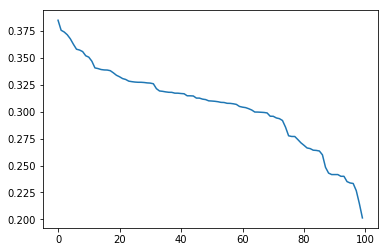

In [8]:
plt.figure()
plot1 = plt.plot(df_error.index.values, df_error["Error"])

## Apresentação da taxa de erro no teste

O grafico abaixo mostra a redução da taxa de erro, durante o teste entre os n-folds, ordenada de forma decrescente. 

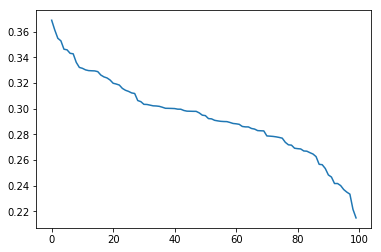

In [249]:
plt.figure()
plot1 = plt.plot(df_error_test.index.values, df_error["Error"])

In [16]:
bestModel = scoresDF.iloc[0, 7]

In [12]:
pred_validation = bestModel.predict(validationData)

In [13]:
printCM(validationLabels, pred_validation)

Confusion Matrix : 
[[11 11]
 [ 5 15]]
Total : 208.0
Acurácia : 0.6190476190476191
Misclassification rate : 0.077
True positives : 0.75
False positives : 0.5
Specificity : 0.5
Precision : 0.6348443223443223
Prevalence : 0.096
Recall : 0.75


(0.6190476190476191, 0.6348443223443223, 0.75)

In [237]:
scoresDF = pd.DataFrame(scores_test, columns=["n-fold", 
                                         "Model Idx",
                                         "Acc", 
                                         "Precision", 
                                         "Recall",
                                         "Error", 
                                         "Alpha", 
                                         "Model"])

scoresDF.sort_values(["Acc","Error"], ascending=False).head(5)

,n-fold,Model Idx,Acc,Precision,Recall,Error,Alpha,Model
92,9,2,0.875000,0.875000,0.909,0.273766,0.487799,"DecisionTreeClassifier(class_weight=None, crit..."
80,8,0,0.875000,0.875000,0.800,0.253333,0.540456,"DecisionTreeClassifier(class_weight=None, crit..."
18,1,8,0.823529,0.831699,0.857,0.297959,0.428518,"DecisionTreeClassifier(class_weight=None, crit..."
47,4,7,0.823529,0.837790,0.800,0.284574,0.460942,"DecisionTreeClassifier(class_weight=None, crit..."
22,2,2,0.823529,0.837790,0.833,0.277014,0.479660,"DecisionTreeClassifier(class_weight=None, crit..."


# Conclusões Finais

Observando através de diversas simulações, podemos ver pelo comportamento do erro de aprendizagem dos modelos na medida que vai sendo minimizado o resultado da acurácia, precisão e recall tende a ambos se equilibrarem de forma a maximizar o desempenho entre eles. 

   Se as metricas acurária/precisão/recall forem observadas individualmente, também podemos ver o aumento de cada uma delas, quando ordenadas ascendentemente, onde ocorre uma convergência. 

   Por essa observação conclui-se que o algoritmo desempenhou o processo esperado em buscar, na redução do erro, o equilibrio maximizado entre falsos positivos e os falsos negativos.